In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/winnie/WIIIN.csv
/kaggle/input/winnie/WIN.csv
/kaggle/input/winnie/WIIN.csv
/kaggle/input/eplplay/ongoing.csv
/kaggle/input/eplplay/endnew.csv
/kaggle/input/eplstand/standing.csv
/kaggle/input/checked/endnew.csv
/kaggle/input/checked/endold.csv
/kaggle/input/standings/standing.csv
/kaggle/input/eplstat/standing.csv
/kaggle/input/newold/endnew.csv
/kaggle/input/newold/endold.xlsx
/kaggle/input/pltables/pl-tables-1993-2024.csv
/kaggle/input/minkah/min.csv
/kaggle/input/allmatch/matches.csv


In [2]:
pip install pandas scikit-learn xgboost tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [4]:
import pandas as pd

# Try reading the CSV file with a different encoding
df = pd.read_csv('/kaggle/input/checked/endold.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataframe
print(df)


       Season        Date     HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  \
0     2000-01  19/08/2000     Charlton       Man City     4     0   H     2   
1     2000-01  19/08/2000      Chelsea       West Ham     4     2   H     1   
2     2000-01  19/08/2000     Coventry  Middlesbrough     1     3   A     1   
3     2000-01  19/08/2000        Derby    Southampton     2     2   D     1   
4     2000-01  19/08/2000        Leeds        Everton     2     0   H     2   
...       ...         ...          ...            ...   ...   ...  ..   ...   
8735  2022-23  28/05/2023      Everton    Bournemouth     1     0   H     0   
8736  2022-23  28/05/2023        Leeds      Tottenham     1     4   A     0   
8737  2022-23  28/05/2023    Leicester       West Ham     2     1   H     1   
8738  2022-23  28/05/2023   Man United         Fulham     2     1   H     1   
8739  2022-23  28/05/2023  Southampton      Liverpool     4     4   D     2   

      HTAG HTR  ... Unnamed: 95 Unnamed: 96  Unname

/tmp/ipykernel_17/2976025880.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/checked/endold.csv', encoding='ISO-8859-1')


In [5]:
# Drop columns with no header and columns that are fully NaN
cleaned_df = df.dropna(axis=1, how='all').drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Show the cleaned dataset's info and the first few rows
cleaned_df_info = cleaned_df.info()
cleaned_df_head = cleaned_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740 entries, 0 to 8739
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      8740 non-null   object 
 1   Date        8740 non-null   object 
 2   HomeTeam    8740 non-null   object 
 3   AwayTeam    8740 non-null   object 
 4   FTHG        8740 non-null   int64  
 5   FTAG        8740 non-null   int64  
 6   FTR         8740 non-null   object 
 7   HTHG        8740 non-null   int64  
 8   HTAG        8740 non-null   int64  
 9   HTR         8740 non-null   object 
 10  Attendance  8739 non-null   object 
 11  Referee     8740 non-null   object 
 12  HS          8740 non-null   int64  
 13  AS          8740 non-null   int64  
 14  HST         8740 non-null   int64  
 15  AST         8740 non-null   int64  
 16  HHW         8740 non-null   int64  
 17  AHW         8740 non-null   int64  
 18  HC          8740 non-null   int64  
 19  AC          8740 non-null  

In [6]:
# Display the first few rows of the DataFrame to understand its structure
print(cleaned_df.head())

    Season        Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  2000-01  19/08/2000  Charlton       Man City     4     0   H     2     0   
1  2000-01  19/08/2000   Chelsea       West Ham     4     2   H     1     0   
2  2000-01  19/08/2000  Coventry  Middlesbrough     1     3   A     1     1   
3  2000-01  19/08/2000     Derby    Southampton     2     2   D     1     2   
4  2000-01  19/08/2000     Leeds        Everton     2     0   H     2     0   

  HTR  ...  IWA   LBH   LBD   LBA   SBH   SBD   SBA   WHH  WHD   WHA  
0   H  ...  2.7  2.20  3.25  2.75  2.20  3.25  2.88  2.10  3.2  3.10  
1   H  ...  4.2  1.50  3.40  6.00  1.50  3.60  6.00  1.44  3.6  6.50  
2   D  ...  2.7  2.25  3.20  2.75  2.30  3.20  2.75  2.30  3.2  2.62  
3   A  ...  3.5  2.20  3.25  2.75  2.05  3.20  3.20  2.00  3.2  3.20  
4   H  ...  4.5  1.55  3.50  5.00  1.57  3.60  5.00  1.61  3.5  4.50  

[5 rows x 45 columns]


In [7]:
# Check for missing values
print(cleaned_df.isnull().sum())

Season          0
Date            0
HomeTeam        0
AwayTeam        0
FTHG            0
FTAG            0
FTR             0
HTHG            0
HTAG            0
HTR             0
Attendance      1
Referee         0
HS              0
AS              0
HST             0
AST             0
HHW             0
AHW             0
HC              0
AC              0
HF              0
AF              0
HO              0
AO              0
HY              0
AY              0
HR              1
AR              1
HBP             1
ABP            14
GBH            97
GBD            97
GBA            87
IWH             6
IWD             6
IWA             3
LBH            61
LBD            61
LBA            60
SBH            56
SBD            56
SBA           504
WHH           455
WHD           455
WHA            11
dtype: int64


In [8]:
print(cleaned_df.dtypes)


Season         object
Date           object
HomeTeam       object
AwayTeam       object
FTHG            int64
FTAG            int64
FTR            object
HTHG            int64
HTAG            int64
HTR            object
Attendance     object
Referee        object
HS              int64
AS              int64
HST             int64
AST             int64
HHW             int64
AHW             int64
HC              int64
AC              int64
HF              int64
AF              int64
HO              int64
AO            float64
HY            float64
AY            float64
HR            float64
AR            float64
HBP           float64
ABP           float64
GBH           float64
GBD           float64
GBA           float64
IWH           float64
IWD           float64
IWA           float64
LBH           float64
LBD           float64
LBA           float64
SBH           float64
SBD           float64
SBA           float64
WHH           float64
WHD           float64
WHA           float64
dtype: obj

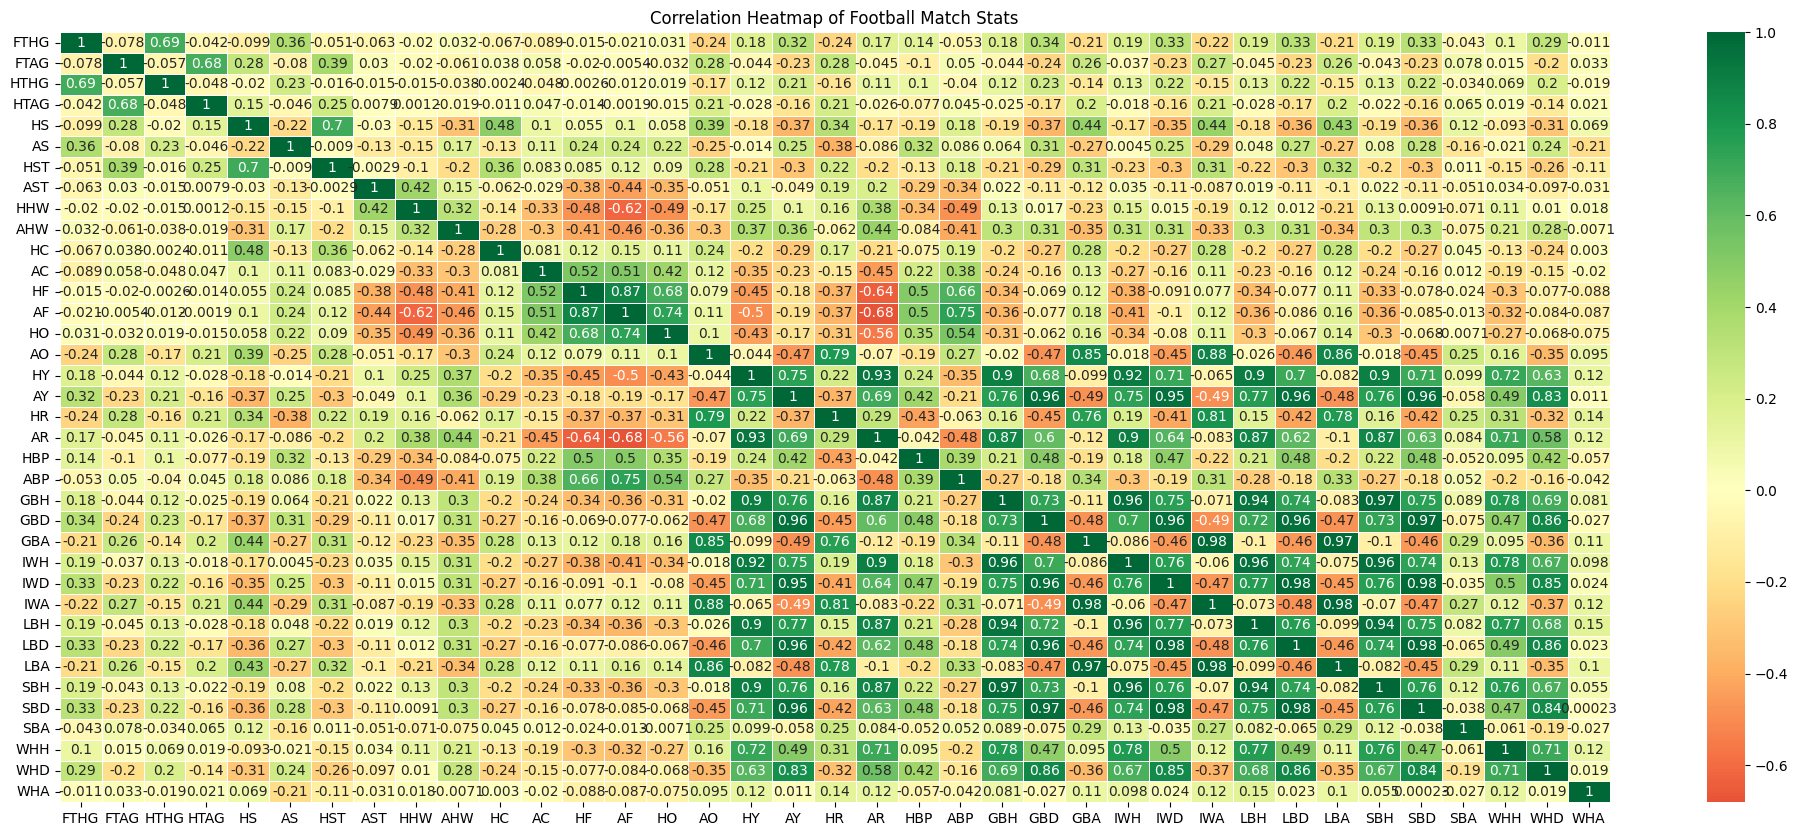

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cleaned_df is your DataFrame

# Drop non-numeric columns for correlation calculation
numeric_df = cleaned_df.select_dtypes(include=[float, int])

# Option: Fill missing values with mean (or any other strategy)
numeric_df_filled = numeric_df.fillna(numeric_df.mean())

# Compute the correlation matrix
corr_matrix = numeric_df_filled.corr()

# Plot the heatmap
plt.figure(figsize=(25, 10))  # Adjust size for better readability
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, linewidths=0.5)

# Set title for heatmap
plt.title('Correlation Heatmap of Football Match Stats')
plt.show()


In [10]:
# Basic statistical description
print(cleaned_df.describe())

              FTHG         FTAG         HTHG         HTAG          HS  \
count  8740.000000  8740.000000  8740.000000  8740.000000  8740.00000   
mean      1.525172     1.159497     0.685011     0.510297    10.96476   
std       1.304593     1.146429     0.835602     0.725208     4.69204   
min       0.000000     0.000000     0.000000     0.000000     0.00000   
25%       1.000000     0.000000     0.000000     0.000000     8.00000   
50%       1.000000     1.000000     0.000000     0.000000    10.00000   
75%       2.000000     2.000000     1.000000     1.000000    14.00000   
max       9.000000     9.000000     5.000000     5.000000    33.00000   

                AS          HST          AST          HHW          AHW  ...  \
count  8740.000000  8740.000000  8740.000000  8740.000000  8740.000000  ...   
mean      6.342792     4.858924    10.592906    10.639817     5.529748  ...   
std       3.490510     2.843338     4.046072     4.856472     3.384828  ...   
min       0.000000     0.0

   feature  importance
0     FTHG    0.520014
1     FTAG    0.479741
5       AS    0.000075
11      AY    0.000069
8       HF    0.000047
12      HR    0.000028
7      AST    0.000017
4       HS    0.000009
3     HTAG    0.000002
2     HTHG    0.000000
6      HST    0.000000
9       AF    0.000000
10      HY    0.000000
13      AR    0.000000


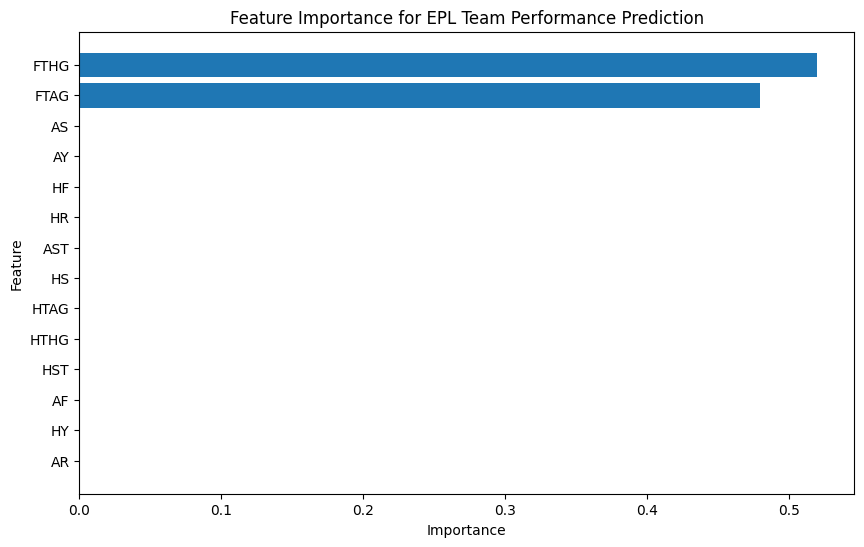

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Select features and target variable
features = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 
            'HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']

X = cleaned_df[features]  # Feature matrix
y = cleaned_df['FTR']  # Target variable (Full-Time Result: 'H', 'A', 'D')

# Encode target variable (FTR) from categorical to numerical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display feature importance
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for EPL Team Performance Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Select features and target variable
features = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 
            'HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
target = 'FTR'

# Encode the target variable
label_encoder = LabelEncoder()
cleaned_df[target] = label_encoder.fit_transform(cleaned_df[target])

# Separate features and target variable
X = cleaned_df[features]
y = cleaned_df[target]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the class distribution in the training set
print(f"Original class distribution: {Counter(y_train)}")

# Applying SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify new class distribution after applying SMOTE
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

# Train a classifier on the resampled dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Original class distribution: Counter({2: 3216, 0: 2038, 1: 1738})
Class distribution after SMOTE: Counter({2: 3216, 1: 3216, 0: 3216})
Confusion Matrix:
 [[505   5   0]
 [  3 430   1]
 [  1   1 802]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       510
           1       0.99      0.99      0.99       434
           2       1.00      1.00      1.00       804

    accuracy                           0.99      1748
   macro avg       0.99      0.99      0.99      1748
weighted avg       0.99      0.99      0.99      1748



In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output accuracy and confusion matrix
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)


Model Accuracy: 99.43%
Confusion Matrix:
[[506   3   1]
 [  3 428   3]
 [  0   0 804]]


In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the SVM model (with linear kernel by default)
svm_model = SVC(random_state=42)

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Output accuracy and confusion matrix
print(f"SVM Model Accuracy: {accuracy_svm * 100:.2f}%")
print("Confusion Matrix for SVM:")
print(conf_matrix_svm)


SVM Model Accuracy: 99.71%
Confusion Matrix for SVM:
[[505   5   0]
 [  0 434   0]
 [  0   0 804]]


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the ANN model
ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train the ANN model
ann_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ann = ann_model.predict(X_test)

# Evaluate the ANN model
accuracy_ann = accuracy_score(y_test, y_pred_ann)
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)

# Output accuracy and confusion matrix
print(f"ANN Model Accuracy: {accuracy_ann * 100:.2f}%")
print("Confusion Matrix for ANN:")
print(conf_matrix_ann)


ANN Model Accuracy: 100.00%
Confusion Matrix for ANN:
[[510   0   0]
 [  0 434   0]
 [  0   0 804]]


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the KNN model (with 5 neighbors by default)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Output accuracy and confusion matrix
print(f"KNN Model Accuracy: {accuracy_knn * 100:.2f}%")
print("Confusion Matrix for KNN:")
print(conf_matrix_knn)


KNN Model Accuracy: 89.19%
Confusion Matrix for KNN:
[[470  37   3]
 [ 67 331  36]
 [  2  44 758]]


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Output accuracy and confusion matrix
print(f"Decision Tree Model Accuracy: {accuracy_dt * 100:.2f}%")
print("Confusion Matrix for Decision Tree:")
print(conf_matrix_dt)


Decision Tree Model Accuracy: 100.00%
Confusion Matrix for Decision Tree:
[[510   0   0]
 [  0 434   0]
 [  0   0 804]]


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
from sklearn.metrics import classification_report

# Define a function to compute performance metrics
def compute_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n" + "="*50 + "\n")

# Compute metrics for each model
compute_metrics(y_test, y_pred, "Random Forest")
compute_metrics(y_test, y_pred_svm, "SVM")
compute_metrics(y_test, y_pred_ann, "ANN")
compute_metrics(y_test, y_pred_knn, "KNN")
compute_metrics(y_test, y_pred_dt, "Decision Tree")


Random Forest Performance Metrics:
Accuracy: 99.43%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Confusion Matrix:
[[506   3   1]
 [  3 428   3]
 [  0   0 804]]


SVM Performance Metrics:
Accuracy: 99.71%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[505   5   0]
 [  0 434   0]
 [  0   0 804]]


ANN Performance Metrics:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[510   0   0]
 [  0 434   0]
 [  0   0 804]]


KNN Performance Metrics:
Accuracy: 89.19%
Precision: 0.89
Recall: 0.89
F1 Score: 0.89
Confusion Matrix:
[[470  37   3]
 [ 67 331  36]
 [  2  44 758]]


Decision Tree Performance Metrics:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[510   0   0]
 [  0 434   0]
 [  0   0 804]]




In [21]:
import pandas as pd

# Create a DataFrame to hold the performance metrics
performance_metrics = {
    'Model': ['Random Forest', 'SVM', 'ANN', 'KNN', 'Decision Tree'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Calculate metrics for each model and append to the DataFrame
for model_name, y_pred in zip(performance_metrics['Model'], 
                               [y_pred, y_pred_svm, y_pred_ann, y_pred_knn, y_pred_dt]):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

# Convert the dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Display the performance metrics DataFrame
print(performance_df)


           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.994279   0.994275  0.994279  0.994271
1            SVM  0.997140   0.997172  0.997140  0.997141
2            ANN  1.000000   1.000000  1.000000  1.000000
3            KNN  0.891876   0.891330  0.891876  0.891263
4  Decision Tree  1.000000   1.000000  1.000000  1.000000


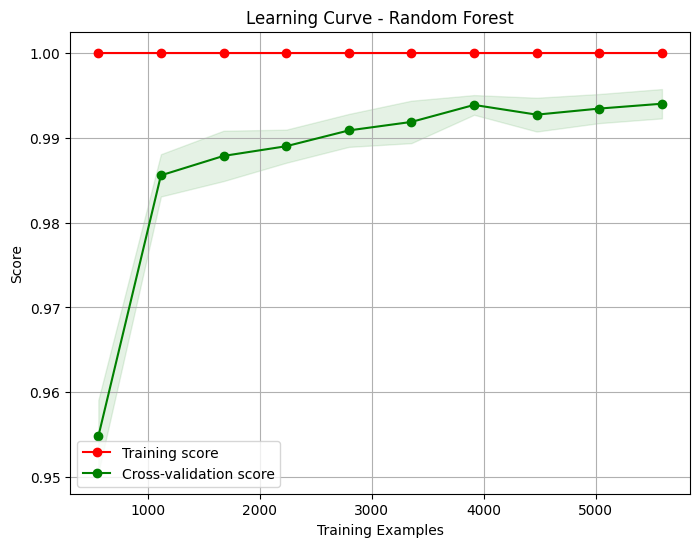

In [22]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
import numpy as np

# Assuming X_train, y_train are already defined (training data)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Generate learning curve values
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()


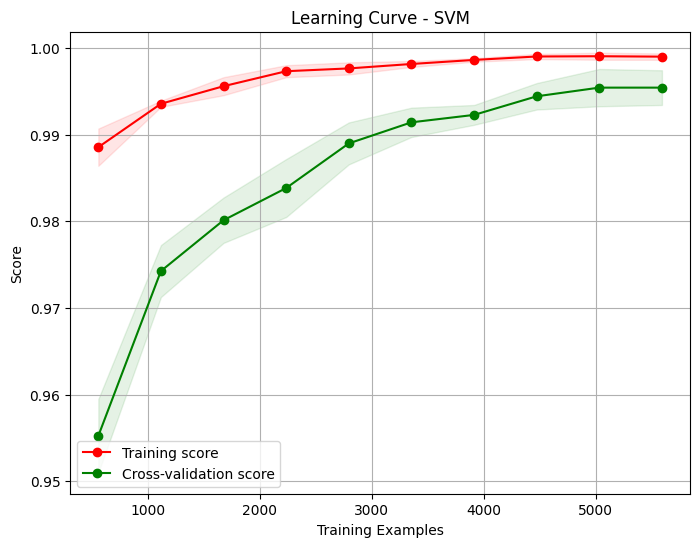

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# Assuming X_train, y_train are already defined (your training data)

# Initialize the SVM model
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)

# Generate learning curve values
train_sizes, train_scores, test_scores = learning_curve(svm_model, X_train, y_train, cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve - SVM')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()


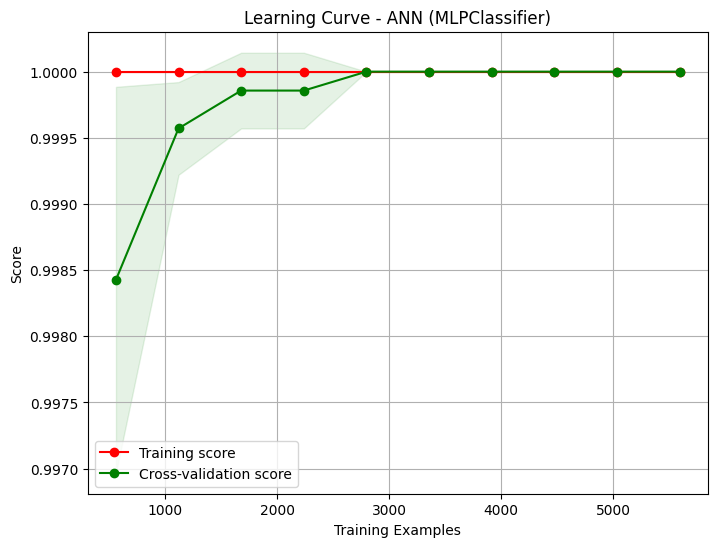

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier

# Assuming X_train, y_train are already defined

# Initialize the MLPClassifier (ANN)
ann_model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)

# Generate learning curve values
train_sizes, train_scores, test_scores = learning_curve(ann_model, X_train, y_train, cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve - ANN (MLPClassifier)')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()


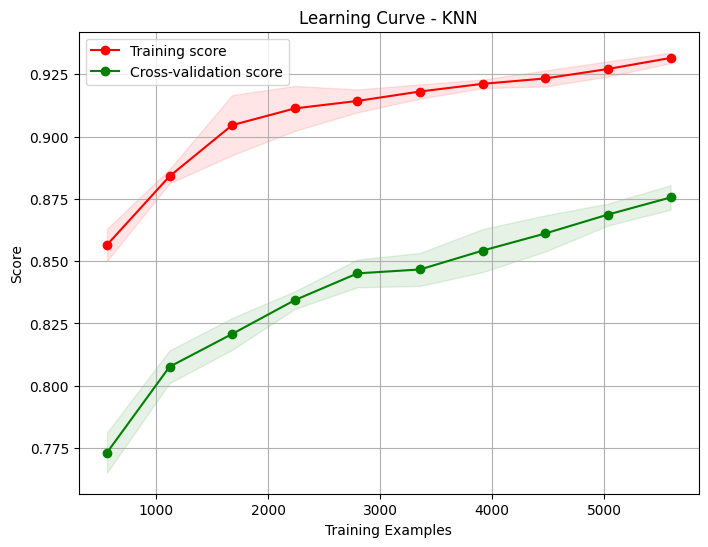

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

# Assuming X_train and y_train are already defined (your training data)

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors based on your preference

# Generate learning curve values
train_sizes, train_scores, test_scores = learning_curve(knn_model, X_train, y_train, cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve - KNN')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()


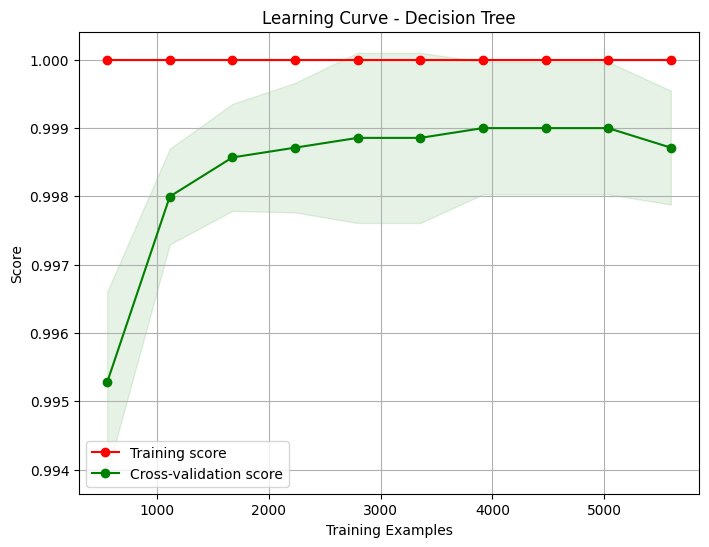

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier

# Assuming X_train and y_train are already defined (your training data)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Generate learning curve values
train_sizes, train_scores, test_scores = learning_curve(dt_model, X_train, y_train, cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve - Decision Tree')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()


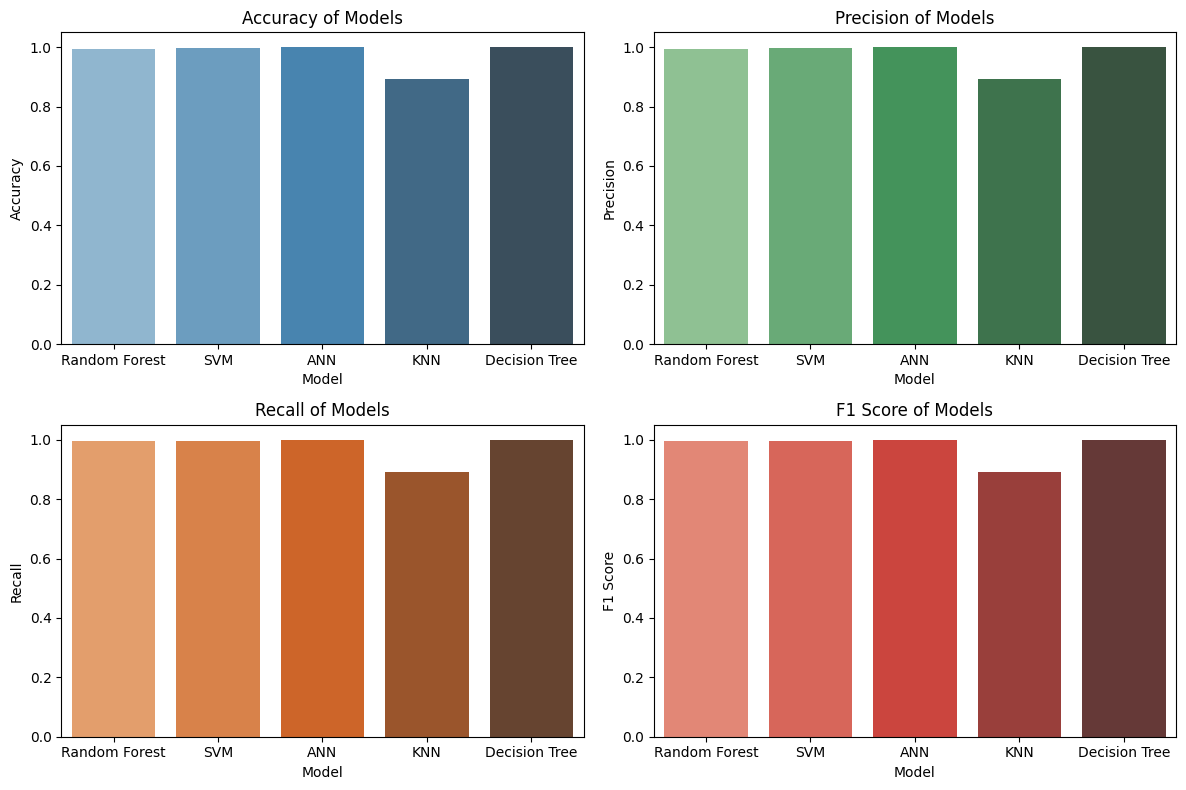

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the performance metrics are already calculated for each model
performance_metrics = {
    'Model': ['Random Forest', 'SVM', 'ANN', 'KNN', 'Decision Tree'],
    'Accuracy': [0.994279, 0.997140, 1.000000, 0.891876 , 1.000000],    # Example values
    'Precision':[0.994275 , 0.997172, 1.000000, 0.891330, 1.000000],   # Example values
    'Recall':   [0.994279, 0.997140, 1.000000, 0.891876, 1.000000],      # Example values
    'F1 Score': [0.994271, 0.997141, 1.000000, 0.891263, 1.000000]     # Example values
}
    
# Convert the dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Visualization using seaborn bar plots
plt.figure(figsize=(12, 8))

# Plot for Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=performance_df, palette='Blues_d')
plt.title('Accuracy of Models')

# Plot for Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=performance_df, palette='Greens_d')
plt.title('Precision of Models')

# Plot for Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall', data=performance_df, palette='Oranges_d')
plt.title('Recall of Models')

# Plot for F1 Score
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='F1 Score', data=performance_df, palette='Reds_d')
plt.title('F1 Score of Models')

# Adjust layout
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
# Try reading the CSV file with a different encoding
df = pd.read_csv('/kaggle/input/newold/endnew.csv', encoding='ISO-8859-1')
# Display the first few rows of the dataframe
print(df)

      Season        Date   Time          HomeTeam       AwayTeam  FTHG  FTAG  \
0    2023-24  11/08/2023  20:00           Burnley       Man City     0     3   
1    2023-24  12/08/2023  12:30           Arsenal  Nott'm Forest     2     1   
2    2023-24  12/08/2023  15:00       Bournemouth       West Ham     1     1   
3    2023-24  12/08/2023  15:00          Brighton          Luton     4     1   
4    2023-24  12/08/2023  15:00           Everton         Fulham     0     1   
..       ...         ...    ...               ...            ...   ...   ...   
375  2023-24  19/05/2024  16:00    Crystal Palace    Aston Villa     5     0   
376  2023-24  19/05/2024  16:00         Liverpool         Wolves     2     0   
377  2023-24  19/05/2024  16:00             Luton         Fulham     2     4   
378  2023-24  19/05/2024  16:00          Man City       West Ham     3     1   
379  2023-24  19/05/2024  16:00  Sheffield United      Tottenham     0     3   

    FTR  HTHG  HTAG  ... AvgC<2.5  AHCh

In [29]:
# Drop columns with no header and columns that are fully NaN
final_df = df.dropna(axis=1, how='all').drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Show the cleaned dataset's info and the first few rows
final_df_info = cleaned_df.info()
final_df_head = cleaned_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740 entries, 0 to 8739
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      8740 non-null   object 
 1   Date        8740 non-null   object 
 2   HomeTeam    8740 non-null   object 
 3   AwayTeam    8740 non-null   object 
 4   FTHG        8740 non-null   int64  
 5   FTAG        8740 non-null   int64  
 6   FTR         8740 non-null   int64  
 7   HTHG        8740 non-null   int64  
 8   HTAG        8740 non-null   int64  
 9   HTR         8740 non-null   object 
 10  Attendance  8739 non-null   object 
 11  Referee     8740 non-null   object 
 12  HS          8740 non-null   int64  
 13  AS          8740 non-null   int64  
 14  HST         8740 non-null   int64  
 15  AST         8740 non-null   int64  
 16  HHW         8740 non-null   int64  
 17  AHW         8740 non-null   int64  
 18  HC          8740 non-null   int64  
 19  AC          8740 non-null  

In [30]:
# Define features and target variable for prediction
features = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']  # Adjust based on your data
X = final_df[features]  # Match features
y = final_df['FTR']  # Full-time result as the target variable


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           A       0.96      1.00      0.98        26
           D       1.00      0.89      0.94        19
           H       0.97      1.00      0.98        31

    accuracy                           0.97        76
   macro avg       0.98      0.96      0.97        76
weighted avg       0.97      0.97      0.97        76

Mean Absolute Error (MAE): 0.03
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.16
Confusion Matrix:
[[26  0  0]
 [ 1 17  1]
 [ 0  0 31]]


In [32]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           A       0.96      1.00      0.98        26
           D       1.00      0.89      0.94        19
           H       0.97      1.00      0.98        31

    accuracy                           0.97        76
   macro avg       0.98      0.96      0.97        76
weighted avg       0.97      0.97      0.97        76

Confusion Matrix:
[[26  0  0]
 [ 1 17  1]
 [ 0  0 31]]


In [33]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [34]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [35]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)


                Team  Points
0           Man City      91
1            Arsenal      89
2          Liverpool      86
3        Aston Villa      68
4          Tottenham      66
5            Chelsea      63
6          Newcastle      60
7         Man United      59
8           West Ham      52
9     Crystal Palace      49
10           Everton      48
11       Bournemouth      48
12            Fulham      47
13          Brighton      47
14            Wolves      46
15         Brentford      39
16     Nott'm Forest      36
17             Luton      26
18           Burnley      24
19  Sheffield United      16


In [36]:
# Drop columns with no header and columns that are fully NaN
final_df = df.dropna(axis=1, how='all').drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Show the cleaned dataset's info and the first few rows
final_df_info = cleaned_df.info()
final_df_head = cleaned_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740 entries, 0 to 8739
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      8740 non-null   object 
 1   Date        8740 non-null   object 
 2   HomeTeam    8740 non-null   object 
 3   AwayTeam    8740 non-null   object 
 4   FTHG        8740 non-null   int64  
 5   FTAG        8740 non-null   int64  
 6   FTR         8740 non-null   int64  
 7   HTHG        8740 non-null   int64  
 8   HTAG        8740 non-null   int64  
 9   HTR         8740 non-null   object 
 10  Attendance  8739 non-null   object 
 11  Referee     8740 non-null   object 
 12  HS          8740 non-null   int64  
 13  AS          8740 non-null   int64  
 14  HST         8740 non-null   int64  
 15  AST         8740 non-null   int64  
 16  HHW         8740 non-null   int64  
 17  AHW         8740 non-null   int64  
 18  HC          8740 non-null   int64  
 19  AC          8740 non-null  

In [37]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Support Vector Machine model
model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf', 'poly', etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        26
           D       1.00      1.00      1.00        19
           H       1.00      1.00      1.00        31

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76

Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
Confusion Matrix:
[[26  0  0]
 [ 0 19  0]
 [ 0  0 31]]


In [38]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Support Vector Machine model
model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf', 'poly', etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        26
           D       1.00      1.00      1.00        19
           H       1.00      1.00      1.00        31

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76

Confusion Matrix:
[[26  0  0]
 [ 0 19  0]
 [ 0  0 31]]


In [39]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [40]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [41]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)


                Team  Points
0           Man City      91
1            Arsenal      89
2          Liverpool      82
3        Aston Villa      68
4          Tottenham      66
5            Chelsea      63
6          Newcastle      60
7         Man United      60
8           West Ham      52
9     Crystal Palace      49
10           Everton      48
11          Brighton      48
12       Bournemouth      48
13            Fulham      47
14            Wolves      46
15         Brentford      39
16     Nott'm Forest      36
17             Luton      26
18           Burnley      24
19  Sheffield United      16


In [42]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.neural_network import MLPClassifier  # Import MLPClassifier for ANN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train an Artificial Neural Network model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # Adjust hidden layers as needed
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.96      0.98        26
           D       0.95      1.00      0.97        19
           H       1.00      1.00      1.00        31

    accuracy                           0.99        76
   macro avg       0.98      0.99      0.98        76
weighted avg       0.99      0.99      0.99        76

Mean Absolute Error (MAE): 0.01
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.11
Confusion Matrix:
[[25  1  0]
 [ 0 19  0]
 [ 0  0 31]]


In [43]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier  # Import MLPClassifier for ANN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train an Artificial Neural Network model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # Adjust hidden layers as needed
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.96      0.98        26
           D       0.95      1.00      0.97        19
           H       1.00      1.00      1.00        31

    accuracy                           0.99        76
   macro avg       0.98      0.99      0.98        76
weighted avg       0.99      0.99      0.99        76

Confusion Matrix:
[[25  1  0]
 [ 0 19  0]
 [ 0  0 31]]


In [44]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [45]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [46]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)


                Team  Points
0           Man City      91
1            Arsenal      89
2          Liverpool      80
3        Aston Villa      68
4          Tottenham      66
5            Chelsea      63
6          Newcastle      60
7         Man United      60
8           West Ham      52
9     Crystal Palace      49
10           Everton      48
11          Brighton      48
12       Bournemouth      48
13            Fulham      47
14            Wolves      46
15         Brentford      39
16     Nott'm Forest      37
17             Luton      26
18           Burnley      24
19  Sheffield United      16


In [47]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier for KNN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a K-Nearest Neighbors model
model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.54
Classification Report:
              precision    recall  f1-score   support

           A       0.57      0.62      0.59        26
           D       0.25      0.26      0.26        19
           H       0.71      0.65      0.68        31

    accuracy                           0.54        76
   macro avg       0.51      0.51      0.51        76
weighted avg       0.55      0.54      0.54        76

Mean Absolute Error (MAE): 0.54
Mean Squared Error (MSE): 0.70
Root Mean Squared Error (RMSE): 0.84
Confusion Matrix:
[[16  9  1]
 [ 7  5  7]
 [ 5  6 20]]


In [48]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier for KNN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a K-Nearest Neighbors model
model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.54
Classification Report:
              precision    recall  f1-score   support

           A       0.57      0.62      0.59        26
           D       0.25      0.26      0.26        19
           H       0.71      0.65      0.68        31

    accuracy                           0.54        76
   macro avg       0.51      0.51      0.51        76
weighted avg       0.55      0.54      0.54        76

Confusion Matrix:
[[16  9  1]
 [ 7  5  7]
 [ 5  6 20]]


In [49]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [50]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)


                Team  Points
0           Man City      91
1            Arsenal      89
2          Liverpool      80
3        Aston Villa      68
4          Tottenham      66
5            Chelsea      63
6          Newcastle      60
7         Man United      60
8           West Ham      52
9     Crystal Palace      49
10           Everton      48
11          Brighton      48
12       Bournemouth      48
13            Fulham      47
14            Wolves      46
15         Brentford      39
16     Nott'm Forest      37
17             Luton      26
18           Burnley      24
19  Sheffield United      16


In [51]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Decision Tree model
model = DecisionTreeClassifier(random_state=42)  # You can specify other parameters like max_depth, min_samples_split, etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.96      0.98        26
           D       0.95      1.00      0.97        19
           H       1.00      1.00      1.00        31

    accuracy                           0.99        76
   macro avg       0.98      0.99      0.98        76
weighted avg       0.99      0.99      0.99        76

Mean Absolute Error (MAE): 0.01
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.11
Confusion Matrix:
[[25  1  0]
 [ 0 19  0]
 [ 0  0 31]]


In [52]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Decision Tree model
model = DecisionTreeClassifier(random_state=42)  # You can specify other parameters like max_depth, min_samples_split, etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.96      0.98        26
           D       0.95      1.00      0.97        19
           H       1.00      1.00      1.00        31

    accuracy                           0.99        76
   macro avg       0.98      0.99      0.98        76
weighted avg       0.99      0.99      0.99        76

Confusion Matrix:
[[25  1  0]
 [ 0 19  0]
 [ 0  0 31]]


In [53]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [54]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [55]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)


                Team  Points
0           Man City      91
1            Arsenal      87
2          Liverpool      82
3        Aston Villa      68
4          Tottenham      66
5            Chelsea      63
6          Newcastle      60
7         Man United      60
8           West Ham      52
9     Crystal Palace      49
10           Everton      48
11          Brighton      48
12       Bournemouth      48
13            Fulham      47
14            Wolves      46
15         Brentford      39
16     Nott'm Forest      36
17             Luton      27
18           Burnley      24
19  Sheffield United      16


In [56]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  # Import SVM

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize individual models
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)  # SVM with probability=True for soft voting
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier(random_state=42)

# Create a Voting Classifier (ensemble) with all models
voting_clf = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('svm', svm),
    ('ann', ann),
    ('knn', knn),
    ('dt', decision_tree)
], voting='soft')  # Use 'hard' for majority voting, 'soft' to average probabilities

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        26
           D       1.00      1.00      1.00        19
           H       1.00      1.00      1.00        31

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76

Confusion Matrix:
[[26  0  0]
 [ 0 19  0]
 [ 0  0 31]]


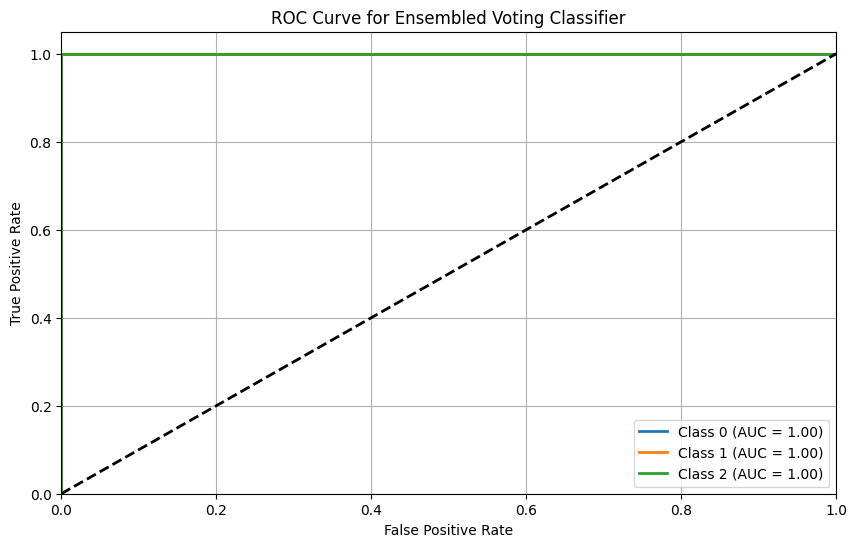

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        31

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import label_binarize

# Assuming you have already trained the ensemble model (voting_clf)
# and split the data into training and testing sets

# Predict probabilities for ensemble model
y_pred_proba = voting_clf.predict_proba(X_test)

# Binarize the output (for multiclass classification)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensembled Voting Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print accuracy and classification report
accuracy = accuracy_score(y_test, voting_clf.predict(X_test))
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, voting_clf.predict(X_test)))


In [58]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes

In [59]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [60]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)

                Team  Points
0           Man City      91
1            Arsenal      87
2          Liverpool      82
3        Aston Villa      68
4          Tottenham      66
5            Chelsea      63
6          Newcastle      60
7         Man United      60
8           West Ham      52
9     Crystal Palace      49
10           Everton      48
11          Brighton      48
12       Bournemouth      48
13            Fulham      47
14            Wolves      46
15         Brentford      39
16     Nott'm Forest      36
17             Luton      27
18           Burnley      24
19  Sheffield United      16


In [61]:
import pandas as pd
# Try reading the CSV file with a different encoding
df = pd.read_csv('//kaggle/input/winnie/WIIIN.csv', encoding='ISO-8859-1')
# Display the first few rows of the dataframe
print(df)

    ï»¿Season        Date   Time     HomeTeam       AwayTeam  FTHG  FTAG FTR  \
0     2023-24  11/08/2023  20:00      Burnley       Man City     0     3   A   
1     2023-24  12/08/2023  12:30      Arsenal  Nott'm Forest     2     1   H   
2     2023-24  12/08/2023  15:00  Bournemouth       West Ham     1     1   D   
3     2023-24  12/08/2023  15:00     Brighton          Luton     4     1   H   
4     2023-24  12/08/2023  15:00      Everton         Fulham     0     1   A   
..        ...         ...    ...          ...            ...   ...   ...  ..   
280   2023-24  16/03/2024  15:00        Luton  Nott'm Forest     1     1   D   
281   2023-24  16/03/2024  17:30       Fulham      Tottenham     3     0   H   
282   2023-24  17/03/2024  14:00     West Ham    Aston Villa     1     1   D   
283   2023-24  30/03/2024  12:30    Newcastle       West Ham     4     3   H   
284   2023-24  30/03/2024  15:00  Bournemouth        Everton     2     1   H   

     HTHG  HTAG  ... AvgC<2.5  AHCh  B3

In [62]:
# Drop columns with no header and columns that are fully NaN
final_df = df.dropna(axis=1, how='all').drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Show the cleaned dataset's info and the first few rows
final_df_info = cleaned_df.info()
final_df_head = cleaned_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740 entries, 0 to 8739
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      8740 non-null   object 
 1   Date        8740 non-null   object 
 2   HomeTeam    8740 non-null   object 
 3   AwayTeam    8740 non-null   object 
 4   FTHG        8740 non-null   int64  
 5   FTAG        8740 non-null   int64  
 6   FTR         8740 non-null   int64  
 7   HTHG        8740 non-null   int64  
 8   HTAG        8740 non-null   int64  
 9   HTR         8740 non-null   object 
 10  Attendance  8739 non-null   object 
 11  Referee     8740 non-null   object 
 12  HS          8740 non-null   int64  
 13  AS          8740 non-null   int64  
 14  HST         8740 non-null   int64  
 15  AST         8740 non-null   int64  
 16  HHW         8740 non-null   int64  
 17  AHW         8740 non-null   int64  
 18  HC          8740 non-null   int64  
 19  AC          8740 non-null  

In [63]:
# Drop columns with no header and columns that are fully NaN
final_df = df.dropna(axis=1, how='all').drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Show the cleaned dataset's info and the first few rows
final_df_info = cleaned_df.info()
final_df_head = cleaned_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740 entries, 0 to 8739
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      8740 non-null   object 
 1   Date        8740 non-null   object 
 2   HomeTeam    8740 non-null   object 
 3   AwayTeam    8740 non-null   object 
 4   FTHG        8740 non-null   int64  
 5   FTAG        8740 non-null   int64  
 6   FTR         8740 non-null   int64  
 7   HTHG        8740 non-null   int64  
 8   HTAG        8740 non-null   int64  
 9   HTR         8740 non-null   object 
 10  Attendance  8739 non-null   object 
 11  Referee     8740 non-null   object 
 12  HS          8740 non-null   int64  
 13  AS          8740 non-null   int64  
 14  HST         8740 non-null   int64  
 15  AST         8740 non-null   int64  
 16  HHW         8740 non-null   int64  
 17  AHW         8740 non-null   int64  
 18  HC          8740 non-null   int64  
 19  AC          8740 non-null  

In [64]:
# Define features and target variable for prediction
features = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']  # Adjust based on your data
X = final_df[features]  # Match features
y = final_df['FTR']  # Full-time result as the target variable

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.95      0.97        20
           D       0.92      0.92      0.92        13
           H       0.96      1.00      0.98        24

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57

Mean Absolute Error (MAE): 0.04
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.19
Confusion Matrix:
[[19  1  0]
 [ 0 12  1]
 [ 0  0 24]]


In [66]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.95      0.97        20
           D       0.92      0.92      0.92        13
           H       0.96      1.00      0.98        24

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57

Confusion Matrix:
[[19  1  0]
 [ 0 12  1]
 [ 0  0 24]]


In [67]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [68]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
280    None
281    None
282    None
283    None
284    None
Length: 285, dtype: object

In [69]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)

                Team  Points
0          Liverpool      66
1            Arsenal      64
2           Man City      63
3        Aston Villa      54
4          Tottenham      53
5         Man United      46
6           West Ham      44
7          Newcastle      43
8           Brighton      42
9             Wolves      41
10           Chelsea      40
11            Fulham      38
12       Bournemouth      38
13           Everton      31
14    Crystal Palace      29
15         Brentford      26
16     Nott'm Forest      25
17             Luton      22
18           Burnley      17
19  Sheffield United      14


In [70]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Support Vector Machine model
model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf', 'poly', etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        20
           D       1.00      1.00      1.00        13
           H       1.00      1.00      1.00        24

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
Confusion Matrix:
[[20  0  0]
 [ 0 13  0]
 [ 0  0 24]]


In [71]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [72]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
280    None
281    None
282    None
283    None
284    None
Length: 285, dtype: object

In [73]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)


                Team  Points
0            Arsenal      64
1          Liverpool      64
2           Man City      63
3        Aston Villa      56
4          Tottenham      53
5         Man United      47
6           West Ham      44
7          Newcastle      43
8           Brighton      42
9             Wolves      41
10           Chelsea      39
11            Fulham      38
12       Bournemouth      38
13           Everton      31
14    Crystal Palace      29
15         Brentford      26
16     Nott'm Forest      25
17             Luton      22
18           Burnley      17
19  Sheffield United      14


In [74]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.neural_network import MLPClassifier  # Import MLPClassifier for ANN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train an Artificial Neural Network model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # Adjust hidden layers as needed
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        20
           D       0.93      1.00      0.96        13
           H       1.00      0.96      0.98        24

    accuracy                           0.98        57
   macro avg       0.98      0.99      0.98        57
weighted avg       0.98      0.98      0.98        57

Mean Absolute Error (MAE): 0.02
Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.13
Confusion Matrix:
[[20  0  0]
 [ 0 13  0]
 [ 0  1 23]]


In [75]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes



In [76]:

# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
280    None
281    None
282    None
283    None
284    None
Length: 285, dtype: object

In [77]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)

                Team  Points
0            Arsenal      64
1          Liverpool      64
2           Man City      63
3        Aston Villa      56
4          Tottenham      51
5         Man United      47
6           West Ham      44
7          Newcastle      43
8           Brighton      42
9             Wolves      41
10           Chelsea      39
11            Fulham      38
12       Bournemouth      38
13           Everton      32
14    Crystal Palace      29
15         Brentford      26
16     Nott'm Forest      25
17             Luton      22
18           Burnley      17
19  Sheffield United      14


In [78]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier for KNN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a K-Nearest Neighbors model
model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           A       0.68      0.75      0.71        20
           D       0.42      0.38      0.40        13
           H       0.83      0.79      0.81        24

    accuracy                           0.68        57
   macro avg       0.64      0.64      0.64        57
weighted avg       0.68      0.68      0.68        57

Mean Absolute Error (MAE): 0.37
Mean Squared Error (MSE): 0.47
Root Mean Squared Error (RMSE): 0.69
Confusion Matrix:
[[15  4  1]
 [ 5  5  3]
 [ 2  3 19]]


In [79]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [80]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
280    None
281    None
282    None
283    None
284    None
Length: 285, dtype: object

In [81]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)

                Team  Points
0           Man City      75
1            Arsenal      68
2          Liverpool      63
3           Brighton      59
4        Aston Villa      57
5          Tottenham      48
6           West Ham      45
7         Man United      45
8        Bournemouth      43
9          Newcastle      43
10            Fulham      43
11    Crystal Palace      41
12            Wolves      31
13           Everton      30
14         Brentford      27
15             Luton      26
16           Chelsea      25
17     Nott'm Forest      23
18  Sheffield United      15
19           Burnley      12


In [82]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Decision Tree model
model = DecisionTreeClassifier(random_state=42)  # You can specify other parameters like max_depth, min_samples_split, etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        20
           D       1.00      1.00      1.00        13
           H       1.00      1.00      1.00        24

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

Confusion Matrix:
[[20  0  0]
 [ 0 13  0]
 [ 0  0 24]]


In [83]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [84]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
280    None
281    None
282    None
283    None
284    None
Length: 285, dtype: object

In [85]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)

                Team  Points
0            Arsenal      64
1          Liverpool      64
2           Man City      63
3        Aston Villa      56
4          Tottenham      53
5         Man United      47
6           West Ham      44
7          Newcastle      43
8           Brighton      42
9             Wolves      41
10           Chelsea      39
11            Fulham      38
12       Bournemouth      38
13           Everton      31
14    Crystal Palace      29
15         Brentford      26
16     Nott'm Forest      25
17             Luton      22
18           Burnley      17
19  Sheffield United      14


In [86]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  # Import SVM

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize individual models
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)  # SVM with probability=True for soft voting
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier(random_state=42)

# Create a Voting Classifier (ensemble) with all models
voting_clf = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('svm', svm),
    ('ann', ann),
    ('knn', knn),
    ('dt', decision_tree)
], voting='soft')  # Use 'hard' for majority voting, 'soft' to average probabilities

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        20
           D       1.00      1.00      1.00        13
           H       1.00      1.00      1.00        24

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

Confusion Matrix:
[[20  0  0]
 [ 0 13  0]
 [ 0  0 24]]


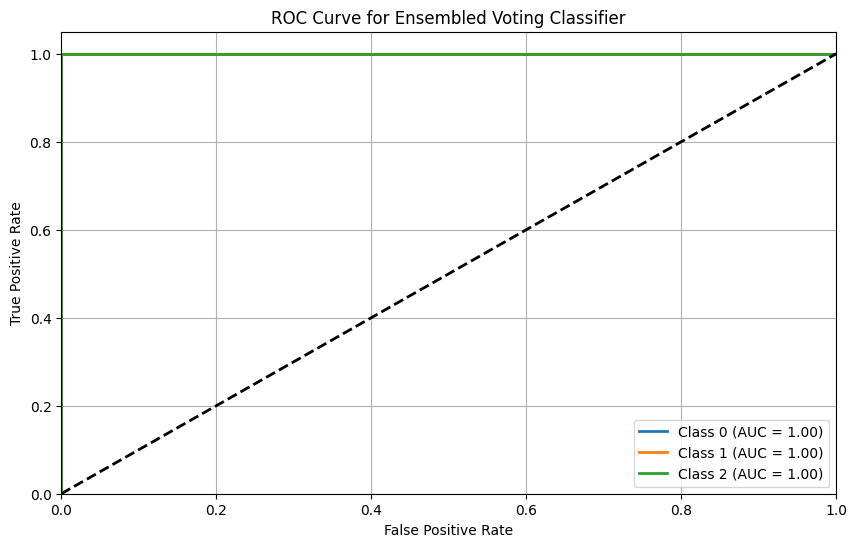

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        24

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import label_binarize

# Assuming you have already trained the ensemble model (voting_clf)
# and split the data into training and testing sets

# Predict probabilities for ensemble model
y_pred_proba = voting_clf.predict_proba(X_test)

# Binarize the output (for multiclass classification)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensembled Voting Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print accuracy and classification report
accuracy = accuracy_score(y_test, voting_clf.predict(X_test))
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, voting_clf.predict(X_test)))

In [88]:
import pandas as pd
# Try reading the CSV file with a different encoding
df = pd.read_csv('//kaggle/input/winnie/WIIN.csv', encoding='ISO-8859-1')
# Display the first few rows of the dataframe
print(df)

    ï»¿Season        Date   Time     HomeTeam       AwayTeam  FTHG  FTAG FTR  \
0     2023-24  11/08/2023  20:00      Burnley       Man City     0     3   A   
1     2023-24  12/08/2023  12:30      Arsenal  Nott'm Forest     2     1   H   
2     2023-24  12/08/2023  15:00  Bournemouth       West Ham     1     1   D   
3     2023-24  12/08/2023  15:00     Brighton          Luton     4     1   H   
4     2023-24  12/08/2023  15:00      Everton         Fulham     0     1   A   
..        ...         ...    ...          ...            ...   ...   ...  ..   
185   2023-24  27/12/2023  20:15      Everton       Man City     1     3   A   
186   2023-24  28/12/2023  19:30     Brighton      Tottenham     4     2   H   
187   2023-24  28/12/2023  20:15      Arsenal       West Ham     0     2   A   
188   2023-24  30/12/2023  12:30        Luton        Chelsea     2     3   A   
189   2023-24  30/12/2023  15:00  Aston Villa        Burnley     3     2   H   

     HTHG  HTAG  ... AvgC<2.5  AHCh  B3

In [89]:
# Drop columns with no header and columns that are fully NaN
final_df = df.dropna(axis=1, how='all').drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Show the cleaned dataset's info and the first few rows
final_df_info = cleaned_df.info()
final_df_head = cleaned_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740 entries, 0 to 8739
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      8740 non-null   object 
 1   Date        8740 non-null   object 
 2   HomeTeam    8740 non-null   object 
 3   AwayTeam    8740 non-null   object 
 4   FTHG        8740 non-null   int64  
 5   FTAG        8740 non-null   int64  
 6   FTR         8740 non-null   int64  
 7   HTHG        8740 non-null   int64  
 8   HTAG        8740 non-null   int64  
 9   HTR         8740 non-null   object 
 10  Attendance  8739 non-null   object 
 11  Referee     8740 non-null   object 
 12  HS          8740 non-null   int64  
 13  AS          8740 non-null   int64  
 14  HST         8740 non-null   int64  
 15  AST         8740 non-null   int64  
 16  HHW         8740 non-null   int64  
 17  AHW         8740 non-null   int64  
 18  HC          8740 non-null   int64  
 19  AC          8740 non-null  

In [90]:
# Define features and target variable for prediction
features = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']  # Adjust based on your data
X = final_df[features]  # Match features
y = final_df['FTR']  # Full-time result as the target variable


In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           A       0.69      0.85      0.76        13
           D       0.60      0.33      0.43         9
           H       0.94      1.00      0.97        16

    accuracy                           0.79        38
   macro avg       0.74      0.73      0.72        38
weighted avg       0.77      0.79      0.77        38

Mean Absolute Error (MAE): 0.21
Mean Squared Error (MSE): 0.21
Root Mean Squared Error (RMSE): 0.46
Confusion Matrix:
[[11  2  0]
 [ 5  3  1]
 [ 0  0 16]]


In [92]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Support Vector Machine model
model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf', 'poly', etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           D       1.00      1.00      1.00         9
           H       1.00      1.00      1.00        16

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
Confusion Matrix:
[[13  0  0]
 [ 0  9  0]
 [ 0  0 16]]


In [93]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.neural_network import MLPClassifier  # Import MLPClassifier for ANN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train an Artificial Neural Network model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # Adjust hidden layers as needed
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           A       0.75      0.92      0.83        13
           D       0.71      0.56      0.63         9
           H       1.00      0.94      0.97        16

    accuracy                           0.84        38
   macro avg       0.82      0.81      0.81        38
weighted avg       0.85      0.84      0.84        38

Mean Absolute Error (MAE): 0.16
Mean Squared Error (MSE): 0.16
Root Mean Squared Error (RMSE): 0.40
Confusion Matrix:
[[12  1  0]
 [ 4  5  0]
 [ 0  1 15]]


In [94]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier for KNN

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a K-Nearest Neighbors model
model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.50
Classification Report:
              precision    recall  f1-score   support

           A       0.53      0.62      0.57        13
           D       0.14      0.11      0.12         9
           H       0.62      0.62      0.62        16

    accuracy                           0.50        38
   macro avg       0.43      0.45      0.44        38
weighted avg       0.48      0.50      0.49        38

Mean Absolute Error (MAE): 0.63
Mean Squared Error (MSE): 0.89
Root Mean Squared Error (RMSE): 0.95
Confusion Matrix:
[[ 8  3  2]
 [ 4  1  4]
 [ 3  3 10]]


In [95]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (you can skip this if using all data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Decision Tree model
model = DecisionTreeClassifier(random_state=42)  # You can specify other parameters like max_depth, min_samples_split, etc.
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.92      0.96        13
           D       1.00      1.00      1.00         9
           H       0.94      1.00      0.97        16

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.98        38
weighted avg       0.98      0.97      0.97        38

Confusion Matrix:
[[12  0  1]
 [ 0  9  0]
 [ 0  0 16]]


In [96]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  # Import SVM

# Encode the target variable (FTR: Home Win, Draw, Away Win)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize individual models
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)  # SVM with probability=True for soft voting
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier(random_state=42)

# Create a Voting Classifier (ensemble) with all models
voting_clf = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('svm', svm),
    ('ann', ann),
    ('knn', knn),
    ('dt', decision_tree)
], voting='soft')  # Use 'hard' for majority voting, 'soft' to average probabilities

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)

# Optional: Confusion Matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           A       0.80      0.92      0.86        13
           D       0.67      0.44      0.53         9
           H       0.88      0.94      0.91        16

    accuracy                           0.82        38
   macro avg       0.78      0.77      0.77        38
weighted avg       0.80      0.82      0.80        38

Confusion Matrix:
[[12  1  0]
 [ 3  4  2]
 [ 0  1 15]]


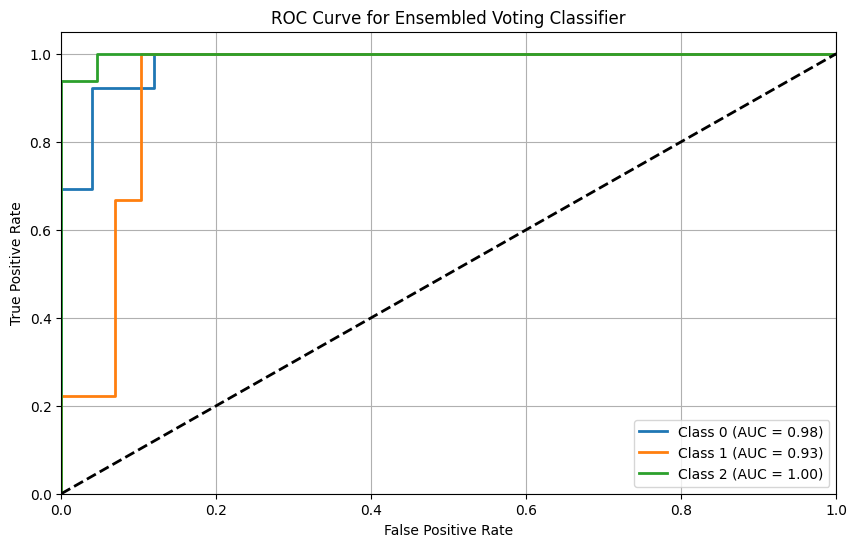

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.67      0.44      0.53         9
           2       0.88      0.94      0.91        16

    accuracy                           0.82        38
   macro avg       0.78      0.77      0.77        38
weighted avg       0.80      0.82      0.80        38



In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import label_binarize

# Assuming you have already trained the ensemble model (voting_clf)
# and split the data into training and testing sets

# Predict probabilities for ensemble model
y_pred_proba = voting_clf.predict_proba(X_test)

# Binarize the output (for multiclass classification)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensembled Voting Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print accuracy and classification report
accuracy = accuracy_score(y_test, voting_clf.predict(X_test))
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, voting_clf.predict(X_test)))

In [98]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)

                Team  Points
0            Arsenal      64
1          Liverpool      64
2           Man City      63
3        Aston Villa      56
4          Tottenham      53
5         Man United      47
6           West Ham      44
7          Newcastle      43
8           Brighton      42
9             Wolves      41
10           Chelsea      39
11            Fulham      38
12       Bournemouth      38
13           Everton      31
14    Crystal Palace      29
15         Brentford      26
16     Nott'm Forest      25
17             Luton      22
18           Burnley      17
19  Sheffield United      14


In [99]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes


In [100]:
# Predict the outcomes of all matches in the last season
last_season_predictions = model.predict(X)

# Decode the predicted labels back to their original format (H, D, A)
predicted_outcomes = label_encoder.inverse_transform(last_season_predictions)

# Add the predicted outcomes to the DataFrame
final_df['Predicted Outcome'] = predicted_outcomes

In [101]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
185    None
186    None
187    None
188    None
189    None
Length: 190, dtype: object

In [102]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
185    None
186    None
187    None
188    None
189    None
Length: 190, dtype: object

In [103]:
# Initialize a dictionary to store team points
team_points = {team: 0 for team in pd.concat([final_df['HomeTeam'], final_df['AwayTeam']]).unique()}

# Function to update points based on predicted outcome
def update_points(row):
    if row['Predicted Outcome'] == 'H':
        team_points[row['HomeTeam']] += 3  # Home win, 3 points to home team
    elif row['Predicted Outcome'] == 'A':
        team_points[row['AwayTeam']] += 3  # Away win, 3 points to away team
    else:
        team_points[row['HomeTeam']] += 1  # Draw, 1 point each
        team_points[row['AwayTeam']] += 1

# Apply the function to all matches
final_df.apply(update_points, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
185    None
186    None
187    None
188    None
189    None
Length: 190, dtype: object

In [104]:
# Convert the team points dictionary into a DataFrame
final_table_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])

# Sort teams by points in descending order
final_table_df = final_table_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Display the predicted final league table
print(final_table_df)


                Team  Points
0        Aston Villa      42
1          Liverpool      42
2           Man City      37
3            Arsenal      37
4          Tottenham      36
5           West Ham      33
6         Man United      31
7           Brighton      30
8          Newcastle      29
9            Chelsea      28
10           Everton      26
11            Wolves      25
12       Bournemouth      25
13            Fulham      21
14         Brentford      19
15    Crystal Palace      18
16             Luton      18
17     Nott'm Forest      17
18           Burnley      11
19  Sheffield United       9
